<a href="https://colab.research.google.com/github/rahiakela/modern-computer-vision-with-pytorch/blob/main/9-image-segmentation/2_instance_segmentation_with_mask_r_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instance Segmentation using Mask R-CNN

The Mask R-CNN architecture helps in identifying/highlighting the instances of
objects of a given class within an image. This comes in especially handy when there are multiple objects of the same type present within the image. Furthermore, the term Mask represents the segmentation that's done at the pixel level by Mask R-CNN.

The Mask R-CNN architecture is an extension of the Faster R-CNN network. However, a few modifications have been made to the Mask R-CNN architecture, as follows:
- The RoI Pooling layer has been replaced with the RoI Align layer.
- A mask head has been included to predict a mask of objects in addition to
the head, which already predicts the classes of objects and bounding box
correction in the final layer.
- A fully convolutional network (FCN) is leveraged for mask prediction.

Let's have a quick look at the events that occur within Mask R-CNN before we
understand how each of the components works (image source: https://arxiv.org/pdf/1703.06870.pdf):

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/MaskR-CNN.png?raw=1' width='800'/>

In the preceding diagram, note that we are fetching the class and bounding box
information from one layer and the mask information from another layer.

The working details of the Mask R-CNN architecture are as follows:

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/MaskR-CNN-architecture.png?raw=1' width='800'/>


## Setup

In [ ]:
%%shell

pip install -qU torch_snippets
pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

     |████████████████████████████████| 61kB 4.0MB/s 
     |████████████████████████████████| 204kB 9.1MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 
     |████████████████████████████████| 51kB 4.7MB/s 


In [ ]:
%%shell

wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/engine.py
wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/utils.py
wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/transforms.py
wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_eval.py
wget --quiet https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_utils.py

In [ ]:
from torch_snippets import *

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from sklearn.model_selection import train_test_split

from engine import train_one_epoch, evaluate
import utils
import transforms as T

import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

[04/12/21 09:02:53] WARNING  Not importing Lightning Report      ]8;id=1618218173.025354-612963;file:///usr/local/lib/python3.7/dist-packages/torch_snippets/torch_loader.py\torch_loader.py]8;;\:<module>:233

                    WARNING  sklearn is not found. Skipping relevant  ]8;id=1618218173.81352-551911;file:///usr/local/lib/python3.7/dist-packages/torch_snippets/__init__.py\__init__.py]8;;\:<module>:13
                             imports from submodule `sklegos`

In [ ]:
%%shell

wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/images.tar
wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/annotations_instance.tar

tar -xf images.tar
tar -xf annotations_instance.tar

rm images.tar annotations_instance.tar

## RoI Align

Imagine a scenario where you've been given an image and been asked to predict
which pixel corresponds to what object. 

So far, when we have been predicting the class of an object and the bounding box corresponding to the object, we passed the image through a network, which then passes the image through a backbone architecture (such as VGG or ResNet), flattens the output at a certain layer, and connects additional dense layers before making predictions for the class and bounding box offsets. 

However, in the case of image segmentation, where the output shape is the same as that of the input image's shape, flattening the convolutions' outputs and then reconstructing the image might result in a loss of information.

Furthermore, the contours and shapes present in the original image will not vary in the output image in the case of image segmentation, so the networks we have dealt with so far (which flatten the last layer and connect additional dense layers) are not optimal when we are performing segmentation.

The two aspects that we need to keep in mind while performing segmentation are as follows:

- The shape and structure of the objects in the original image remain the
same in the segmented output.
- Leveraging a fully convolutional architecture (and not a structure where
we flatten a certain layer) can help here since we are using one image as
input and another as output.

The U-Net architecture helps us achieve this. A typical representation of U-Net is as follows (the input image is of the shape `3 x 96 x 128`, while the number of classes present in the image is 21; this means that the output contains 21 channels):

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/unet.png?raw=1' width='800'/>

**The preceding architecture is called a U-Net architecture because of its "U"-like shape.**

In the left half of the preceding diagram, we can see that the image passes through convolution layers, and that the image size keeps reducing while the number of channels keeps increasing. However, in the right half, we can see that we are upscaling the downscaled image, back to the original height and width but with as many channels as there are classes.

**In addition, while upscaling, we are also leveraging information from the
corresponding layers in the left half using skip connections so that we can preserve the structure/objects in the original image.**

**This way, the U-Net architecture learns to preserve the structure (and shapes of objects) of the original image while leveraging the convolution's features to predict the classes that correspond to each pixel.**

In general, we have as many channels in the output as the number of classes we want to predict.

### Performing upscaling

In the U-Net architecture, upscaling is performed using the nn.ConvTranspose2d
method, which takes the number of input channels, the number of output channels, the kernel size, and stride as input parameters.

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/upscaling.png?raw=1' width='800'/>

In the preceding example, we took an input array of shape `3 x 3` (Input array), applied a stride of 2 where we distributed the input values to accommodate the stride (Input array adjusted for stride), padded the array with zeros (Input array adjusted for stride and padding), and convolved the padded input with a filter (Filter/Kernel) to fetch the output array.

In order to understand how nn.ConvTranspose2d helps upscale an array, let's go
through the following code:

In [ ]:
# Initialize a network, m, with the nn.ConvTranspose2d method by specifying input channel's value is 1, output channel's value is 1
m = nn.ConvTranspose2d(1, 1, kernel_size=(2, 2), stride=2, padding=0)

Internally, padding is calculated as `dilation * (kernel_size - 1) - padding`.

Hence `1*(2-1)-0 = 1`, where we add zero padding of 1 to both dimensions of
the input array.

In [ ]:
# Initialize an input array and pass it through the model
input = torch.ones(1, 1, 3, 3)
output = m(input)
print(output.shape)

torch.Size([1, 1, 6, 6])

In [ ]:
output

tensor([[[[-0.3843,  0.1646, -0.3843,  0.1646, -0.3843,  0.1646],
          [-0.5957, -0.5920, -0.5957, -0.5920, -0.5957, -0.5920],
          [-0.3843,  0.1646, -0.3843,  0.1646, -0.3843,  0.1646],
          [-0.5957, -0.5920, -0.5957, -0.5920, -0.5957, -0.5920],
          [-0.3843,  0.1646, -0.3843,  0.1646, -0.3843,  0.1646],
          [-0.5957, -0.5920, -0.5957, -0.5920, -0.5957, -0.5920]]]],
       grad_fn=<SlowConvTranspose2DBackward>)

## Implementing semantic segmentation

We'll leverage the U-Net architecture to predict the class that
corresponds to all the pixels in the image. A sample of such an input-output
combination is as follows:

<img src='https://github.com/rahiakela/img-repo/blob/master/object-detection-images/semantic-segmentation.png?raw=1' width='800'/>

Note that, in the preceding picture, the objects that belong to the same class (in the left image – the input image) have the same pixel value (in the right image – the output image), which is why we are segmenting the pixels that are semantically similar to each other. This is also known as **semantic segmentation**.

**Step-1**: Define the function that will be used to transform images.

In [ ]:
tfms = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                        
])

**Step-2:** Define the dataset class.

In [ ]:
class SegmentationData(Dataset):

  def __init__(self, split):
    self.items = stems(f"dataset1/images_prepped_{split}")
    self.split = split

  def __len__(self):
    return len(self.items)

  def __getitem__(self, ix):
    image = read(f'dataset1/images_prepped_{self.split}/{self.items[ix]}.png', 1)
    image = cv2.resize(image, (224,224))
    mask = read(f'dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png')
    mask = cv2.resize(mask, (224,224))

    return image, mask 

  def choose(self): 
    return self[randint(len(self))]

  def collate_fn(self, batch):
    ims, masks = list(zip(*batch))
    ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
    ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
    
    return ims, ce_masks

**Step-3:** Define the training and validation datasets, as well as the dataloaders.

In [ ]:
train_ds = SegmentationData("train")
val_ds = SegmentationData("test")

train_dataloader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=train_ds.collate_fn)
val_dataloader = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

[04/12/21 09:21:49] INFO     367 files found at                           ]8;id=1618219309.662518-981252;file:///usr/local/lib/python3.7/dist-packages/torch_snippets/loader.py\loader.py]8;;\:stems:198
                             dataset1/images_prepped_train

                    INFO     101 files found at                           ]8;id=1618219309.669717-878539;file:///usr/local/lib/python3.7/dist-packages/torch_snippets/loader.py\loader.py]8;;\:stems:198
                             dataset1/images_prepped_test

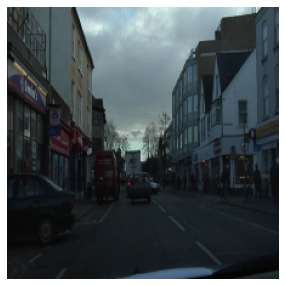

In [ ]:
show(train_ds[10][0])

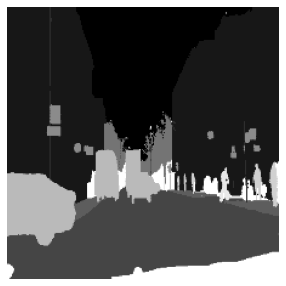

In [ ]:
show(train_ds[10][1])

**Step-4:** Define the neural network model.

We are sequentially performing the `Conv2d` operation, the `BatchNorm2d` operation, and the `ReLU` operation.

Let's define the convolution block.

In [ ]:
def conv(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
  )

`ConvTranspose2d` ensures that we upscale the images. This differs
from the `Conv2d` operation, where we reduce the dimensions of the
image. It takes an image that has `in_channels` number of channels as
input channels and produces an image that has `out_channels`
number of output channels.

Let's define the up_conv block.

In [ ]:
def up_conv(in_channels, out_channels):
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
      nn.ReLU(inplace=True)
  )

We are making the U-style connection between the downscaling and upscaling convolution features by using `torch.cat` on the appropriate pairs of tensors.

Let's define the network class (UNet).

In [ ]:
class UNet(nn.Module):

  def __init__(self, pretrained=True, out_channels=12):
    super().__init__()

    self.encoder = vgg16_bn(pretrained=pretrained).features
    self.block1 = nn.Sequential(*self.encoder[:6])
    self.block2 = nn.Sequential(*self.encoder[6:13])
    self.block3 = nn.Sequential(*self.encoder[13:20])
    self.block4 = nn.Sequential(*self.encoder[20:27])
    self.block5 = nn.Sequential(*self.encoder[27:34])
    
    self.bottleneck = nn.Sequential(*self.encoder[34:])
    self.conv_bottleneck = conv(512, 1024)

    self.up_conv6 = up_conv(1024, 512)
    self.conv6 = conv(512+512, 512)

    self.up_conv7 = up_conv(512, 256)
    self.conv7 = conv(256+512, 256)

    self.up_conv8 = up_conv(256, 128)
    self.conv8 = conv(128+256, 128)

    self.up_conv9 = up_conv(128, 64)
    self.conv9 = conv(64+128, 64)

    self.up_conv10 = up_conv(64, 32)
    self.conv10 = conv(32+64, 32)

    self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

  def forward(self, x):
    block1 = self.block1(x)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    block4 = self.block4(block3)
    block5 = self.block5(block4)

    bottleneck = self.bottleneck(block5)
    x = self.conv_bottleneck(bottleneck)

    x = self.up_conv6(x)
    x = torch.cat([x, block5], dim=1)
    x = self.conv6(x)

    x = self.up_conv7(x)
    x = torch.cat([x, block4], dim=1)
    x = self.conv7(x)

    x = self.up_conv8(x)
    x = torch.cat([x, block3], dim=1)
    x = self.conv8(x)

    x = self.up_conv9(x)
    x = torch.cat([x, block2], dim=1)
    x = self.conv9(x)

    x = self.up_conv10(x)
    x = torch.cat([x, block1], dim=1)
    x = self.conv10(x)

    x = self.conv11(x)

    return x

Let's define a function (UNetLoss) that will calculate our loss and accuracy
values:

In [ ]:
ce = nn.CrossEntropyLoss()

def UnetLoss(preds, targets):
  ce_loss = ce(preds, targets)
  acc = (torch.max(preds, 1)[1] == targets).float().mean()

  return ce_loss, acc

Let's define a function that will train on batch (`train_batch`) and calculate
metrics on the validation dataset (`validate_batch`):

In [ ]:
def train_batch(model, data, optimizer, criterion):
  model.train()

  ims, ce_masks = data
  _masks = model(ims)
  optimizer.zero_grad()
  loss, acc = criterion(_masks, ce_masks)
  loss.backward()
  optimizer.step()

  return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
  model.eval()

  ims, masks = data
  _masks = model(ims)
  loss, acc = criterion(_masks, masks)

  return loss.item(), acc.item()

Let's define the model, optimizer, loss function, and the number of epochs:

In [ ]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

**Step-5:** Train the model over increasing epochs.

In [ ]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(train_dataloader)
    for bx, data in enumerate(train_dataloader):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dataloader)
    for bx, data in enumerate(val_dataloader):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)

EPOCH: 1.000	trn_loss: 1.138	trn_acc: 0.733	val_loss: 0.849	val_acc: 0.790	(1074.43s - 20414.20s remaining)
EPOCH: 2.000	trn_loss: 0.687	trn_acc: 0.822	val_loss: 0.646	val_acc: 0.844	(2152.43s - 19371.87s remaining)
EPOCH: 3.000	trn_loss: 0.552	trn_acc: 0.850	val_loss: 0.567	val_acc: 0.851	(3223.51s - 18266.54s remaining)
EPOCH: 4.000	trn_loss: 0.505	trn_acc: 0.862	val_loss: 0.508	val_acc: 0.860	(4292.75s - 17171.00s remaining)
EPOCH: 5.000	trn_loss: 0.472	trn_acc: 0.869	val_loss: 0.482	val_acc: 0.865	(5364.96s - 16094.89s remaining)
EPOCH: 6.000	trn_loss: 0.434	trn_acc: 0.879	val_loss: 0.530	val_acc: 0.846	(6439.35s - 15025.15s remaining)
EPOCH: 7.000	trn_loss: 0.420	trn_acc: 0.880	val_loss: 0.455	val_acc: 0.862	(7509.76s - 13946.70s remaining)
EPOCH: 8.000	trn_loss: 0.378	trn_acc: 0.892	val_loss: 0.518	val_acc: 0.831	(8587.07s - 12880.60s remaining)
EPOCH: 9.000	trn_loss: 0.359	trn_acc: 0.898	val_loss: 0.492	val_acc: 0.857	(9667.44s - 11815.76s remaining)
EPOCH: 10.000	trn_loss: 0.33

**Step-6:** Plot the training, validation loss, and accuracy values over increasing epochs:

100%|██████████| 121/121 [00:00<00:00, 737.01it/s]


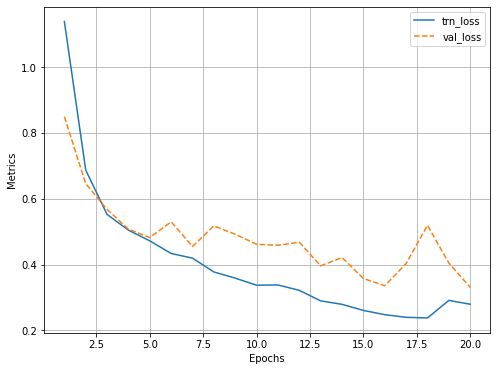

In [ ]:
log.plot_epochs(['trn_loss','val_loss'])

**Step-7:** Calculate the predicted output on a new image.

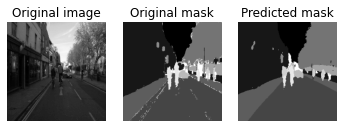

In [ ]:
im, mask = next(iter(val_dataloader))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)

subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], 
          mask.permute(1,2,0).detach().cpu()[:,:,0],
          _mask.permute(1,2,0).detach().cpu()[:,:,0]],
          nc=3, titles=['Original image','Original mask','Predicted mask']
        )

We can see that we can successfully generate a segmentation mask using the U-Net architecture. However, all instances of the same class will have the same predicted pixel value. 

What if we want to separate the instances of the Person class in the image? So, we will learn about the **Mask R-CNN** architecture, which helps with generating instance-level masks so that we can differentiate between instances (even instances of the same class).